In [1]:
import pandas as pd
import numpy as np
import backtest
import matplotlib.pyplot as plt 

from log_data import StockData

import os

from dotenv import load_dotenv
from log_data import StockData
from datetime import datetime

import sys
import backtest

# Baixando dados das ações
df = pd.read_parquet('cotacoes_acoes.parquet')
df_ibov = pd.read_parquet('ibov.parquet')
df_ibov.rename(columns={'indice': 'ticker', 'valor': 'preco_fechamento_ajustado'}, inplace=True)
df_ibov['ticker'] = df_ibov['ticker'].replace('IBOV', 'BOVA11')
df_smal =  pd.read_parquet('smll.parquet')
df_smal.rename(columns={'indice': 'ticker', 'valor': 'preco_fechamento_ajustado'}, inplace=True)
df_smal['ticker'] = df_smal['ticker'].replace('SMLL', 'SMAL11')
df_ibov['data'] = pd.to_datetime(df_ibov['data']); df_smal['data'] = pd.to_datetime(df_smal['data'])
df = pd.concat([df, df_ibov, df_smal], ignore_index=True)
df.fillna(0, inplace=True)
df.info()

## upload data
load_dotenv()
ambiente_local = os.getenv('AMBIENTE_MAC')
datapath_cdi = 'cdi_historico.xlsx'
cdi_data = backtest.cdidata_extract(ambiente_local+datapath_cdi)
print(type(cdi_data))
print(len(cdi_data))
print(cdi_data[0:20])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1650895 entries, 0 to 1650894
Data columns (total 12 columns):
 #   Column                     Non-Null Count    Dtype         
---  ------                     --------------    -----         
 0   data                       1650895 non-null  datetime64[ns]
 1   preco_abertura             1650895 non-null  float64       
 2   preco_fechamento           1650895 non-null  float64       
 3   preco_maximo               1650895 non-null  float64       
 4   preco_medio                1650895 non-null  float64       
 5   preco_minimo               1650895 non-null  float64       
 6   quantidade_negociada       1650895 non-null  float64       
 7   quantidade_negocios        1650895 non-null  float64       
 8   ticker                     1650895 non-null  object        
 9   volume_negociado           1650895 non-null  float64       
 10  fator_ajuste               1650895 non-null  float64       
 11  preco_fechamento_ajustado  1650895 no

In [2]:
# Dados ativos mais líquidos mes a mes
def valores_unicos_df(dataframe):
    valores_unicos = []
    for coluna in dataframe.columns[1:]:
        valores_unicos_coluna = list(dataframe[coluna].unique())
        valores_unicos.extend(valores_unicos_coluna)
    valores_unicos = list(set(valores_unicos))

    return valores_unicos

# Função para extrair o ano (primeiros 4 caracteres)
def extrair_ano(data):
    return data[:4]

# Função para extrair o valor após o hífen
def extrair_apos_hifen(data):
    partes = data.split('-')
    if len(partes) > 1:
        return partes[1]
    else:
        return None  

portfolio_liquidez = pd.read_csv('portfolio_quant.csv', delimiter=',', header=None)
# tickers_strategy = valores_unicos_df(portfolio_liquidez)
portfolio_liquidez.tail(5)
portfolio_liquidez.shape
# portfolio_liquidez = portfolio_liquidez.iloc[:, 0:5]
portfolio_liquidez['Ano'] = portfolio_liquidez[0].apply(extrair_ano)
portfolio_liquidez['Mes'] = portfolio_liquidez[0].apply(extrair_apos_hifen)
tickers_strategy = valores_unicos_df(portfolio_liquidez)
portfolio_liquidez.head(5)


,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,Ano,Mes
0,2000-1,PETR4,BBDC4,ELET6,CMIG4,ELET3,PETR3,CSNA3,CPLE6,SBSP3,...,ETER3,RAPT4,FESA4,SHUL4,ALPA4,ITSA4,USIM5,EMBR3,2000,1
1,2000-2,PETR4,CMIG4,BBDC4,ELET6,PETR3,ELET3,CPLE6,CSNA3,SBSP3,...,FESA4,ALPA4,RAPT4,ETER3,SHUL4,ITSA4,MYPK3,EMBR3,2000,2
2,2000-3,PETR4,CMIG4,BBDC4,ELET6,ELET3,PETR3,CSNA3,CPLE6,SBSP3,...,ETER3,FESA4,RAPT4,ALPA4,ITSA4,USIM5,EMBR3,MYPK3,2000,3
3,2000-4,PETR4,BBDC4,CMIG4,ELET6,PETR3,ELET3,CSNA3,CPLE6,SBSP3,...,ETER3,FESA4,RAPT4,SHUL4,ALPA4,ITSA4,USIM5,EMBR3,2000,4
4,2000-5,PETR4,BBDC4,CMIG4,ELET6,PETR3,ELET3,CSNA3,SBSP3,CPLE6,...,ETER3,FESA4,RAPT4,ALPA4,SHUL4,ITSA4,MYPK3,RANI3,2000,5


In [3]:
# Objeto dados das ações
stock_data = StockData(df, tickers_selecionados=tickers_strategy)

stock_data.dates = stock_data.dates[:-2]
stock_data.price_matrix = stock_data.price_matrix[:-2, :]

print(len(tickers_strategy))
print(type(tickers_strategy))
print(stock_data.price_matrix.shape)
valores_nao_comuns = [valor for valor in tickers_strategy if valor not in stock_data.tickers]
weekdays = [StockData.date_to_weekday(date) for date in stock_data.dates]
print(weekdays[:5])
print(valores_nao_comuns)

# vamos colocar nome aos bois
# falar com o joao: acho melhor pegar as 20 mais do IBOVESPA. pq vem muito lixo nesse sistema que ele criou.
# > dates = dias 
# > tickers = ações
# > price matrix = precos
# > weekdays = dias da semana
# > tickers_strategy = todas as ações utilizadas na estratégia 
# > portfolio_liquidez = df com as ações mais líquidas de cada mês

# o que farei primeiro é tentar usar o dataframe para rodar o backtest
# verificar as saídas minuciosamente
# aumentar o escopo
# finalizar o programa - analisar volatilidade das quedas

# depois tentar rodar com numpy arrays
# depois colocar em classes e funções
# lembrar dos algorimos de jogos

In [ ]:
# Verificação Ativos Início e Fim
assets_trading = 'Ativos backtest: '
for ticker in stock_data.tickers:
    assets_trading += ticker+' , '

print(assets_trading, '\n')
print('Inicio Backtest: ', stock_data.dates[0])
print('Fim do Backtest: ', stock_data.dates[-1])
print('Return Benchmark _ Strategy Long Bova11: ', round( stock_data.price_matrix[-1,stock_data.tickers.index('BOVA11')]/ stock_data.price_matrix[0,stock_data.tickers.index('BOVA11')] - 1, 2))

Ativos backtest: ITSA4 , VALE3 , EMBR3 , EQTL3 , BRFS3 , PETR3 , HYPE3 , PETR4 , ETER3 , LIGT3 , RAPT4 , CCRO3 , ELET6 , ELET3 , BRKM5 , TUPY3 , GGBR4 , MRFG3 , GFSA3 , USIM5 , BRAP4 , WEGE3 , GRND3 , GOLL4 , GOAU4 , LREN3 , MRVE3 , FESA4 , MULT3 , MYPK3 , FLRY3 , POSI3 , BBDC3 , SANB11 , ROMI3 , ITUB4 , SHUL4 , CYRE3 , CSNA3 , CPFE3 , CPLE6 , ALPA4 , VULC3 , JBSS3 , BBAS3 , DASA3 , BBDC4 , UNIP6 , TOTS3 , SBSP3 , CMIG4 , KEPL3 , RENT3 , CIEL3 , CSAN3 , RANI3 , UGPA3 , BRPR3 , ECOR3 , MGLU3 , QUAL3 , RADL3 , BBSE3 , ABEV3 , KLBN11 , CVCB3 , PRIO3 , BPAC11 , RAIL3 , AZUL4 , CRFB3 , IRBR3 , SUZB3 , B3SA3 , HAPV3 , COGN3 , NTCO3 , CASH3 , RRRP3 , RDOR3 , ASAI3 , AMER3 , VBBR3 , BOVA11 , SMAL11 ,  

Inicio Backtest:  2010-01-04 00:00:00
Fim do Backtest:  2023-10-27 00:00:00
Return Benchmark _ Strategy Long Bova11:  0.62


In [ ]:
# backtest
contagem_dias = np.zeros(stock_data.price_matrix.shape[1])
capital_alocacao = np.zeros((stock_data.price_matrix.shape[0], stock_data.price_matrix.shape[1] + 1))
resultado_alocacao = np.zeros((stock_data.price_matrix.shape[0], stock_data.price_matrix.shape[1] + 1))
capital_alocacao[0, -1] = 1

# Alocação portfolio
retorno_treshold = -0.025
periodo_position = 5 # input("Nr de dias posicionado: ")
cash = 1.0


for i, day in enumerate(stock_data.dates):

    # identificar mes e ano
    ano = day.year; mes = day.month
    cash = capital_alocacao[0, -1]
    
    # pegar a linha do joao com o portfolio desejado
    stocks2trade = portfolio_liquidez[(portfolio_liquidez['Ano'] == str(ano)) & (portfolio_liquidez['Mes'] == str(mes))]    
    if not stocks2trade.empty:
        stocks2trade = stocks2trade.iloc[0,1:-2].tolist()
    else:
        stocks2trade = []
        print('Falta mes e ano na portfolio de liquidez')
        sys.exit()        

    for i2, tickers in enumerate(stocks2trade):
        # print(f'\nAno: {ano} e mês: {mes}')            
        # print(f'Ação {i2} : {tickers}')
        if tickers != 'XPBR31':

            capital_alocacao[i, stock_data.tickers.index(tickers)] = capital_alocacao[i-1, stock_data.tickers.index(tickers)]

            if stock_data.price_matrix[i, stock_data.tickers.index(tickers)] != 0:

                if capital_alocacao[i, stock_data.tickers.index(tickers)] != 0:

                    contagem_dias[stock_data.tickers.index(tickers)] += 1

                    if contagem_dias[stock_data.tickers.index(tickers)] >= int(periodo_position): 

                        # capital_alocacao[i, stock_data.tickers.index(tickers)], cash = backtest.simple_update_capital(cash, 'sell')
                        capital_alocacao[i, stock_data.tickers.index(tickers)] = 0
                        contagem_dias[stock_data.tickers.index(tickers)] = 0 

                if weekdays[i] == 'sexta':
                    preco_ontem = stock_data.price_matrix[i-1, stock_data.tickers.index(tickers)]
                    # print(weekdays[i-1])
                    preco_sextapassada = stock_data.price_matrix[i-4, stock_data.tickers.index(tickers)]
                    # print(weekdays[i-4])
                    retorno_semanal = backtest.calculate_return(preco_sextapassada, preco_ontem)
                    # print(f'Retorno semanal: {retorno_semanal}, de acordo com {weekdays[i-4]} e {weekdays[i-1]}.')

                    if retorno_semanal > retorno_treshold and cash >= 0.10:
                        capital_alocacao[i, stock_data.tickers.index(tickers)], cash = backtest.simple_update_capital(cash, 'buy')                        
                        contagem_dias[stock_data.tickers.index(tickers)] = 0
                    
                    else:
                        continue

    if cash < -0.001 or cash > 1:
        print('SYSTEM ERROR - cash out of reality')
        print(cash)
        sys.exit()
    else:
        # cash = 1 - np.sum(capital_alocacao[i, :-1])
        capital_alocacao[i, -1] = cash
                
                # pass

/Users/gabrielassuncao/CARTOR/quant/quant_research_2023/backtest.py:8: RuntimeWarning: divide by zero encountered in scalar divide
  return end_price / start_price - 1


In [ ]:
capital_alocacao[30:40,:]

array([[0.1, 0.1, 0. , 0. , 0.1, 0.1, 0. , 0.1, 0. , 0. , 0. , 0. , 0. ,
        0.1, 0. , 0.1, 0.1, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0.1,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0.1,
        0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0. , 0. , 0.1, 0. ,
        0. , 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 1. ],
       [0.1, 0.1, 0. , 0. , 0.1, 0.1, 0. , 0.1, 0. , 0. , 0. , 0. , 0. ,
        0.1, 0. , 0.1, 0.1, 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0.1,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0.1,
        0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0.1, 0. , 0. , 0. , 0.1, 0. ,
        0. , 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
        0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ],
       [0.1, 0.1, 0. , 0. 

In [ ]:
print(stock_data.tickers.index('PETR4'))
stock_data.price_matrix[-1, stock_data.tickers.index('PETR4')]

7


35.44

In [ ]:
# plt.plot(stock_data.price_matrix[:,3])
print(stock_data.price_matrix.shape)
print(len(stock_data.dates))
print(len(stock_data.tickers))

(3424, 85)
3424
85


In [ ]:
# Building Equity Curve // Revisar
equity =[100]

for i, day in enumerate(stock_data.dates[1:], start=1):

    for i2, ticker in enumerate(stock_data.tickers):

        if stock_data.price_matrix[i-1, i2] != 0: 

            position_ticker = capital_alocacao[i, i2]

            day_return = backtest.calculate_return(stock_data.price_matrix[i-1, i2], stock_data.price_matrix[i, i2])

            resultado_alocacao[i, i2] = position_ticker*day_return

    equity.append((np.sum(resultado_alocacao[i, :])) * equity[i-1] + equity[i-1])

In [ ]:
# # Building Equity Curve with cash
# equity_cash =[100]

# date_structure = backtest.datestring_tostruct(stock_data.dates)

# for i, day in enumerate(stock_data.dates[1:], start=1):

#     for i2 in range(capital_alocacao.shape[1]):

#         if i2 == (capital_alocacao.shape[1]-1): # if it is cash
#             linhas_correspondentes = cdi_data[(cdi_data[:, 2] == date_structure[i,1]) & (cdi_data[:, 3] == date_structure[i,2])]
#             position_ticker = capital_alocacao[i, i2]
#             day_return = (linhas_correspondentes[0][1]+1)**(1/252)-1
#             resultado_alocacao[i, i2] = position_ticker*day_return

#         elif stock_data.price_matrix[i-1, i2] != 0: 
#             position_ticker = capital_alocacao[i, i2]
#             day_return = backtest.calculate_return(stock_data.price_matrix[i-1, i2], stock_data.price_matrix[i, i2])
#             resultado_alocacao[i, i2] = position_ticker*day_return

#     equity_cash.append((np.sum(resultado_alocacao[i, :])) * equity_cash[i-1] + equity_cash[i-1])

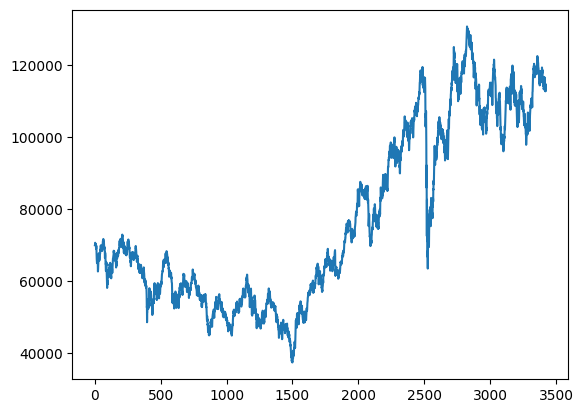

In [ ]:
# Building Equity Curve BOVA 11 // Revisar
plt.plot(stock_data.price_matrix[:, stock_data.tickers.index('BOVA11')])

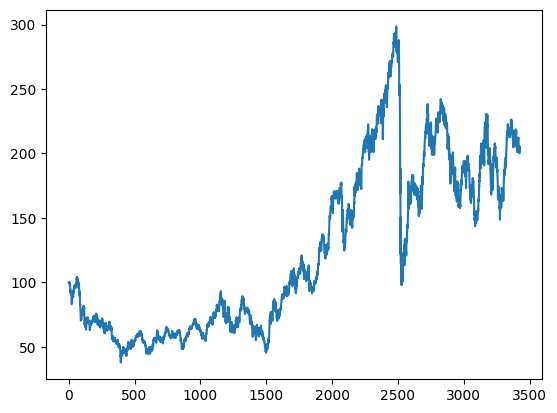

In [ ]:
plt.plot(equity)

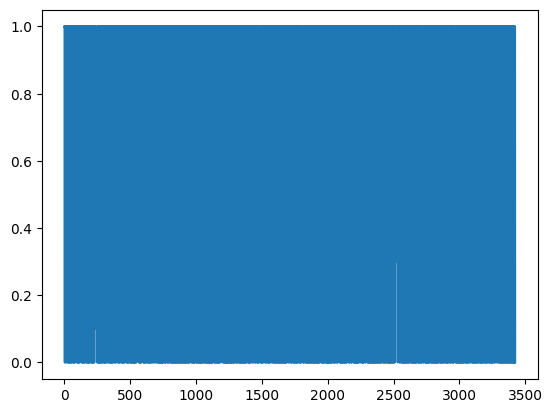

In [ ]:
plt.plot(capital_alocacao[:,-1])